In [4]:
#Talend ETL job run

import subprocess

talend_job_path = r'D:\sai\sample_file_load_0.1\sample_file_load\sample_file_load_run.bat'

parameters = [
    '--context_param', 'url=https://raw.githubusercontent.com/saikrishna9899/DSE_project/main/Computer_Assisted_Mass_Appraisal_Residential.csv',
    '--context_param', 'DetinationDirectory=C:/Users/lenovo/Downloads/',
    '--context_param', 'DetinationFilename=Computer_Assisted_Mass_Appraisal_Residential.csv',
    '--context_param', 'InputFilename=C:/Users/lenovo/Downloads/Computer_Assisted_Mass_Appraisal_Residential.csv'
]

command = [talend_job_path] + parameters

# Call the Talend job using subprocess
subprocess.run(command, shell=True)


CompletedProcess(args=['D:\\sai\\sample_file_load_0.1\\sample_file_load\\sample_file_load_run.bat', '--context_param', 'url=https://raw.githubusercontent.com/saikrishna9899/DSE_project/main/Computer_Assisted_Mass_Appraisal_Residential.csv', '--context_param', 'DetinationDirectory=C:/Users/lenovo/Downloads/', '--context_param', 'DetinationFilename=Computer_Assisted_Mass_Appraisal_Residential.csv', '--context_param', 'InputFilename=C:/Users/lenovo/Downloads/Computer_Assisted_Mass_Appraisal_Residential.csv'], returncode=0)

In [2]:
# Import Libraries
import pandas as pd
import dask.dataframe as dd

In [4]:
#Snowflake database Connection
import snowflake.connector
conn_params = {
    'account': 'osa14176.east-us-2.azure',
    'user': 'saikrishna',
    'password': 'Sai@9490984187',
    'warehouse': 'COMPUTE_WH',
    'database': 'DE_SAMPLE_DB',
    'schema': 'DEV'
}

# Establish a connection
conn = snowflake.connector.connect(**conn_params)

In [5]:

cursor = conn.cursor()

# Define the SQL query
query = "SELECT * FROM Apartment"  

# Execute the query and fetch the data
sales = pd.read_sql(query, conn)

print(sales)

C:\Users\chigi\AppData\Local\Temp\ipykernel_37096\1916011658.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales = pd.read_sql(query, conn)


                 SSL  BATHRM  HF_BATHRM  HEAT         HEAT_D AC  NUM_UNITS  \
0       0093    0080     5.0        0.0   1.0     Forced Air  Y        3.0   
1       0093    0081     3.0        1.0  13.0  Hot Water Rad  Y        2.0   
2       0093    0082     4.0        2.0   7.0      Warm Cool  Y        2.0   
3       0093    0083     2.0        0.0   7.0      Warm Cool  Y        2.0   
4       0093    0084     3.0        1.0  13.0  Hot Water Rad  Y        1.0   
...              ...     ...        ...   ...            ... ..        ...   
108517  PAR 02510068     1.0        0.0   7.0      Warm Cool  Y        1.0   
108518  PAR 02510069     2.0        1.0  13.0  Hot Water Rad  N        1.0   
108519  PAR 02510075     1.0        0.0  13.0  Hot Water Rad  N        1.0   
108520  PAR 02510076     1.0        1.0   7.0      Warm Cool  Y        1.0   
108521  PAR 02510077     1.0        1.0   1.0     Forced Air  N        1.0   

        ROOMS  BEDRM     AYB  ...  ROOF        ROOF_D  INTWALL 

In [6]:
### Preprocessing

sale_year = sales["SALEDATE_YEAR"].astype(int)
sale_month = sales["SALEDATE_MONTH"].astype(int)
sale_day = sales["SALEDATE_DAY"].astype(int)

print(sale_day)


0         30
1         13
2         23
3         12
4         28
          ..
108517    23
108518     7
108519     1
108520     1
108521     1
Name: SALEDATE_DAY, Length: 108522, dtype: int32


In [7]:
# Create a variable for the month name
month_names = ("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
sales["sale_named_month"] = sale_month.map(lambda x: month_names[x-1])

print(sales["sale_named_month"])

0             March
1         September
2          November
3               May
4          December
            ...    
108517    September
108518     February
108519      January
108520      January
108521      January
Name: sale_named_month, Length: 108522, dtype: object


In [8]:
# Convert to an ordered categorical variable
sales["sale_named_month"] = pd.Categorical(sales["sale_named_month"], categories = month_names, ordered = True)
sales["sale_named_month"].head()

0        March
1    September
2     November
3          May
4     December
Name: sale_named_month, dtype: category
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']

In [9]:
# Create a boolean variable for if the property sold for a price over $)
sales.insert(sales.columns.get_loc("PRICE")+1, "with_prices", sales["PRICE"].apply(lambda x: False if x == 0 else True))

# Create a boolean for if the property was remodeled
sales.insert(sales.columns.get_loc("YR_RMDL")+1, "remodeled", sales["YR_RMDL"].notnull())

In [10]:
import pandas as pd

# Assuming "SALEDATE" is the column containing date values
sales["SALEDATE"] = pd.to_datetime(sales["SALEDATE"])

# Now you can perform datetime operations on the "SALEDATE" column
# Create variables looking at how much time has passed since January 1 2010, the start date of the subset we are working with
def year_diff(a, b):
    return (a.dt.year - b.year)

def month_diff(a, b):
    return 12 * (a.dt.year - b.year) + (a.dt.month - b.month)

sales["num_years_passed"] = year_diff(sales["SALEDATE"], pd.Timestamp("2010/01/01 00:00:00+00"))
sales["num_months_passed"] = month_diff(sales["SALEDATE"], pd.Timestamp("2010/01/01 00:00:00+00"))
sales["num_days_passed"] = (sales["SALEDATE"] - pd.Timestamp("2010/01/01 00:00:00+00")).dt.days


In [11]:
## Sales per year
print(sale_year.value_counts())

SALEDATE_YEAR
1900    17522
2021     8432
2022     7636
2020     6434
2019     5524
        ...  
1968        2
1955        1
1962        1
1956        1
1947        1
Name: count, Length: 68, dtype: int64


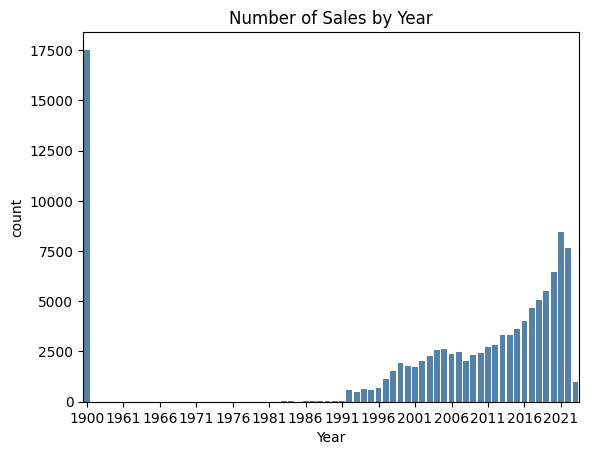

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of sales per year
year_graph_data = sale_year.value_counts().rename_axis(["sale_year"]).reset_index(name = "count")

year_graph = sns.barplot(data = year_graph_data, x = "sale_year", y = "count", color = "steelblue")
year_graph.set(title = "Number of Sales by Year", xlabel = "Year")
year_graph.set_xticks(range(0, 69, 5))
plt.show()

In [13]:
# Assuming 'sales' is your original DataFrame
# Assuming 'sale_year' is a column in the 'sales' DataFrame

# Apply the conditions to filter the DataFrame
sales_trimmed = sales[(sale_year >= 2010) & (sale_year < 2023) & sales["PRICE"].notnull()]

# Number of rows in your subset missing sale price
print(len(sales_trimmed))

# We can add more variables if we identify more unneeded variables
cols_to_drop = ["SSL", "GIS_LAST_MOD_DTTM", "OBJECTID"]

# Drop the specified columns
sales_trimmed = sales_trimmed.drop(cols_to_drop, axis=1)
print(sales_trimmed)


59975
        BATHRM  HF_BATHRM  HEAT         HEAT_D AC  NUM_UNITS  ROOMS  BEDRM  \
0          5.0        0.0   1.0     Forced Air  Y        3.0   10.0    6.0   
1          3.0        1.0  13.0  Hot Water Rad  Y        2.0    8.0    4.0   
2          4.0        2.0   7.0      Warm Cool  Y        2.0   11.0    3.0   
3          2.0        0.0   7.0      Warm Cool  Y        2.0    8.0    4.0   
4          3.0        1.0  13.0  Hot Water Rad  Y        1.0   13.0    6.0   
...        ...        ...   ...            ... ..        ...    ...    ...   
108503     2.0        1.0   7.0      Warm Cool  Y        1.0    7.0    3.0   
108512     2.0        0.0   1.0     Forced Air  Y        1.0    6.0    3.0   
108513     1.0        0.0   1.0     Forced Air  N        1.0    4.0    2.0   
108515     2.0        1.0  13.0  Hot Water Rad  N        1.0    9.0    4.0   
108517     1.0        0.0   7.0      Warm Cool  Y        1.0    5.0    2.0   

           AYB  YR_RMDL  ...  INTWALL  INTWALL_D  KITCHEN

In [14]:
#%%
### EDA

#%%
print(sales_trimmed.shape)
print(sales_trimmed.info())
# For this it makes sense to only use sales where the property sold for a price, not for $0
sales_trimmed_with_price = sales_trimmed[sales_trimmed["with_prices"] == True]



(59975, 45)
<class 'pandas.core.frame.DataFrame'>
Index: 59975 entries, 0 to 108517
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   BATHRM             59112 non-null  float64            
 1   HF_BATHRM          59112 non-null  float64            
 2   HEAT               59112 non-null  float64            
 3   HEAT_D             59975 non-null  object             
 4   AC                 59975 non-null  object             
 5   NUM_UNITS          59112 non-null  float64            
 6   ROOMS              59067 non-null  float64            
 7   BEDRM              59103 non-null  float64            
 8   AYB                59960 non-null  float64            
 9   YR_RMDL            37175 non-null  float64            
 10  remodeled          59975 non-null  bool               
 11  EYB                59975 non-null  int64              
 12  STORIES            59003 non-null  flo

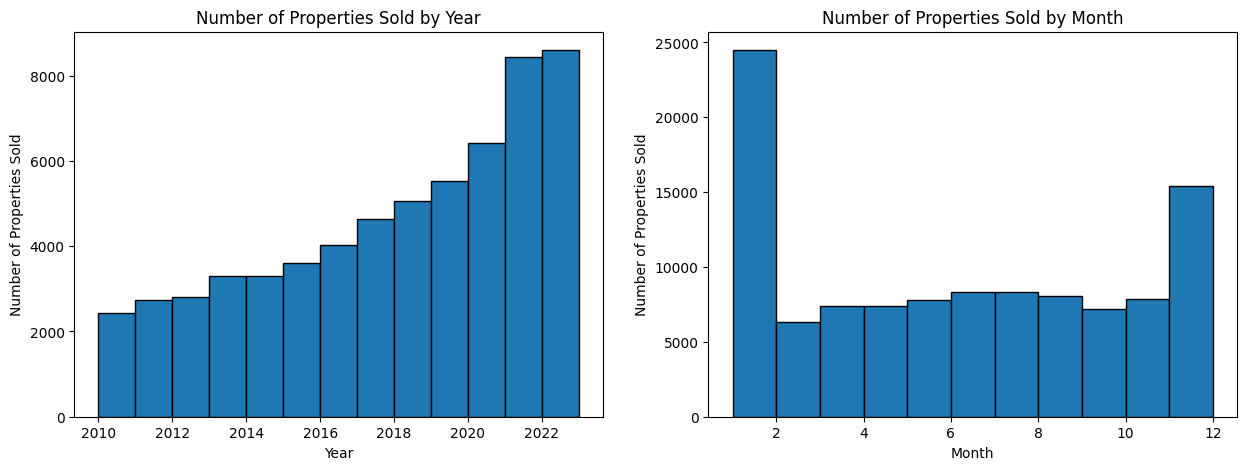

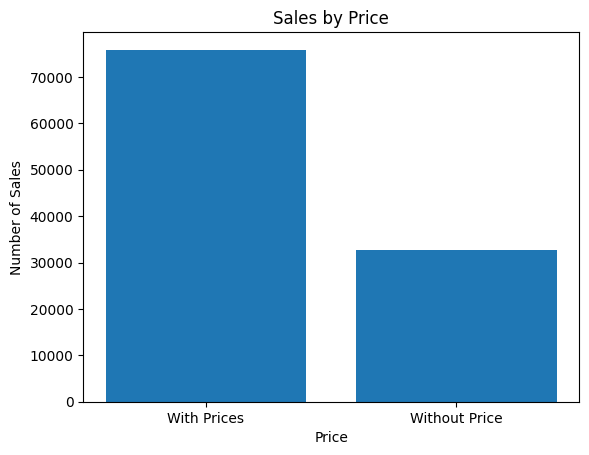

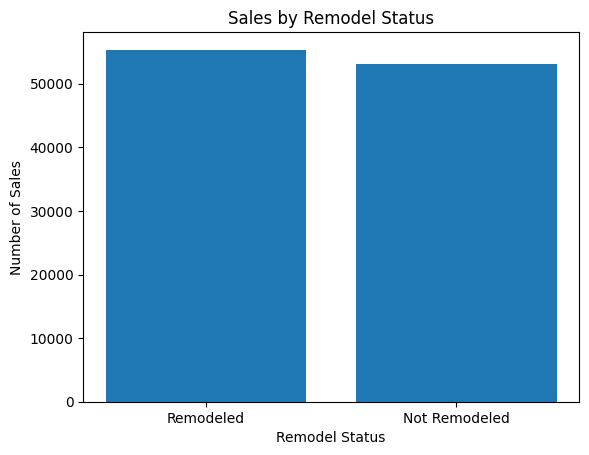

In [15]:

#%%

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

# Histogram of the number of properties sold by year
axs[0].hist(sale_year, bins=range(2010,2024), edgecolor='black')
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Number of Properties Sold")
axs[0].set_title("Number of Properties Sold by Year")

# Histogram of the number of properties sold by month
axs[1].hist(sale_month, bins=range(1,13), edgecolor='black')
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Number of Properties Sold")
axs[1].set_title("Number of Properties Sold by Month")

plt.show()


price_counts = sales["with_prices"].value_counts()

# Bar chart of the sales by price
plt.bar(["With Prices", "Without Price"], price_counts.values)
plt.xlabel("Price")
plt.ylabel("Number of Sales")
plt.title("Sales by Price")
plt.show()

# Total Count of number of sales with and without a remodel
remodel_counts = sales["remodeled"].value_counts()

# Bar chart of the sales by remodel status
plt.bar(["Remodeled", "Not Remodeled"], remodel_counts.values)
plt.xlabel("Remodel Status")
plt.ylabel("Number of Sales")
plt.title("Sales by Remodel Status")
plt.show()
# Sales per year with price vs no price stacked bar chart``



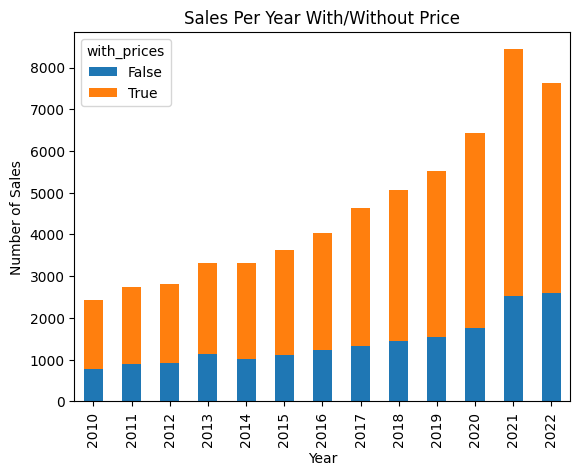

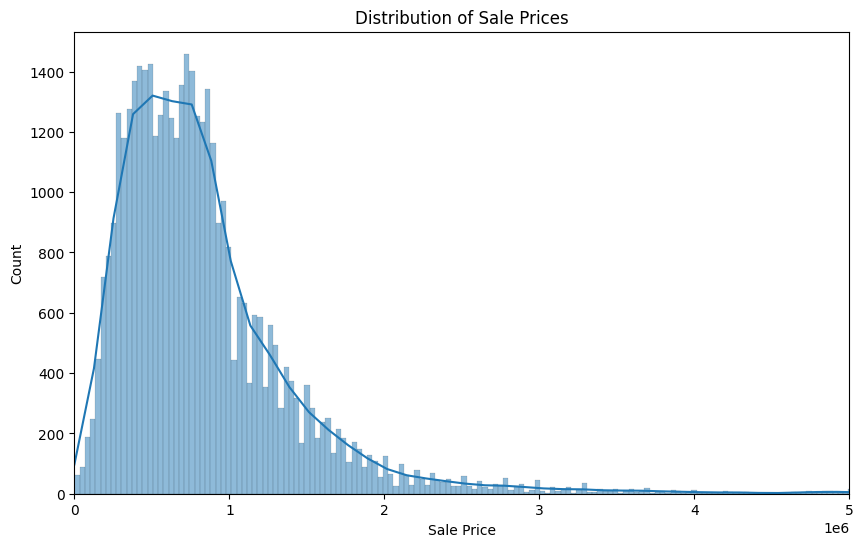

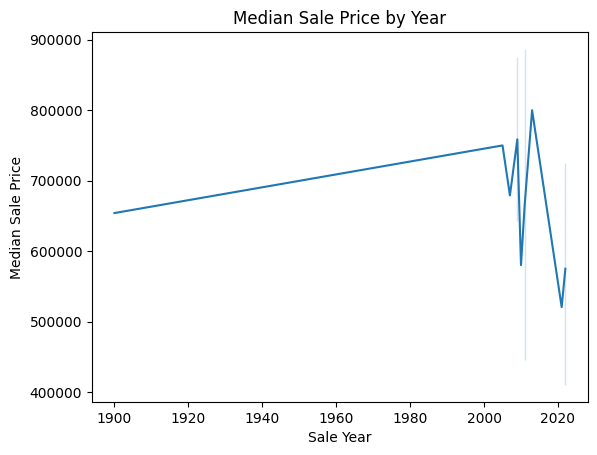

In [16]:
#change to years 2010 throough 2021
sales_subset = sales[(sale_year >= 2010) & (sale_year < 2023)]
sales_with_price = sales_subset.groupby([sale_year, "with_prices"]).size().unstack(fill_value=0)
sales_with_price.plot(kind="bar", stacked=True)
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.title("Sales Per Year With/Without Price")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(sales_trimmed_with_price['PRICE'], kde=True)
plt.xlim(0, 0.5e7)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.show()


median_prices_by_year = sales_trimmed_with_price.groupby(sale_year)["PRICE"].median().reset_index(name="median_price")

sns.lineplot(x=sale_year, y="median_price", data=median_prices_by_year)
plt.xlabel("Sale Year")
plt.ylabel("Median Sale Price")
plt.title("Median Sale Price by Year")
plt.show()

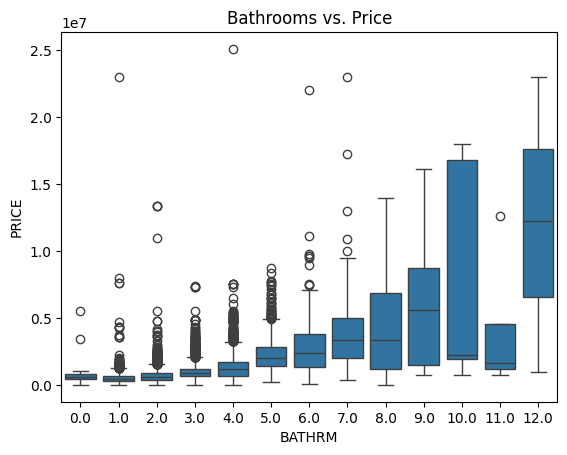

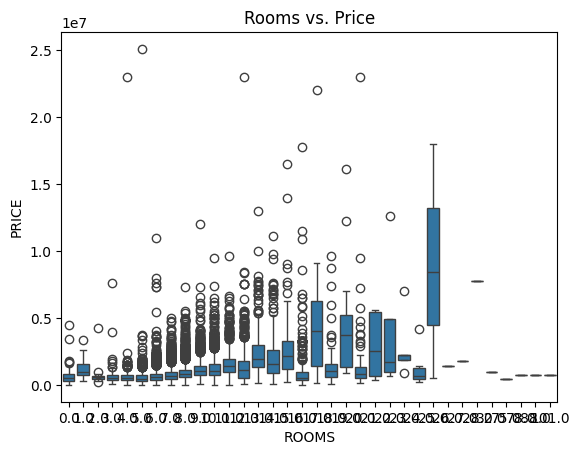

In [17]:
#%%
# Creating scatterplots of highly correlated variables
sns.boxplot(x='BATHRM', y='PRICE', data=sales_trimmed_with_price)
plt.title('Bathrooms vs. Price')
plt.show()

sns.boxplot(x='ROOMS', y='PRICE', data=sales_trimmed_with_price)
plt.title('Rooms vs. Price')
plt.show()



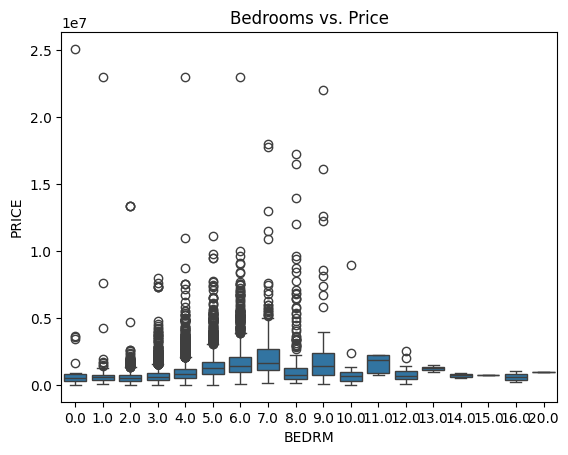

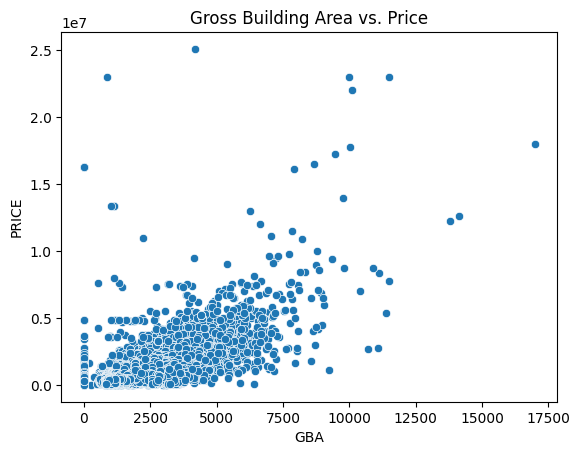

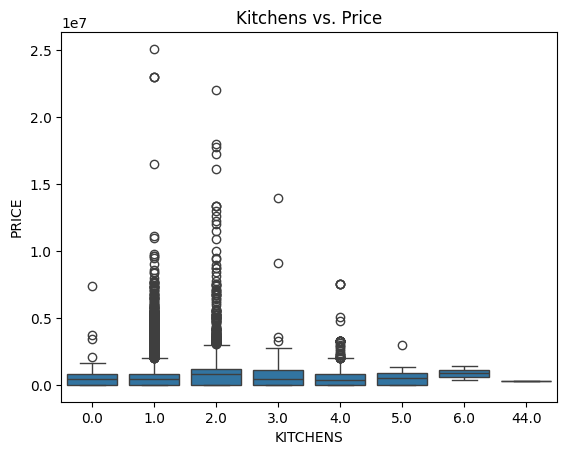

In [18]:
sns.boxplot(x='BEDRM', y='PRICE', data=sales_trimmed_with_price)
plt.title('Bedrooms vs. Price')
plt.show()

sns.scatterplot(x='GBA', y='PRICE', data=sales_trimmed_with_price)
plt.title('Gross Building Area vs. Price')
plt.show()

sns.boxplot(x='KITCHENS', y='PRICE', data=sales_trimmed)
plt.title('Kitchens vs. Price')
plt.show()

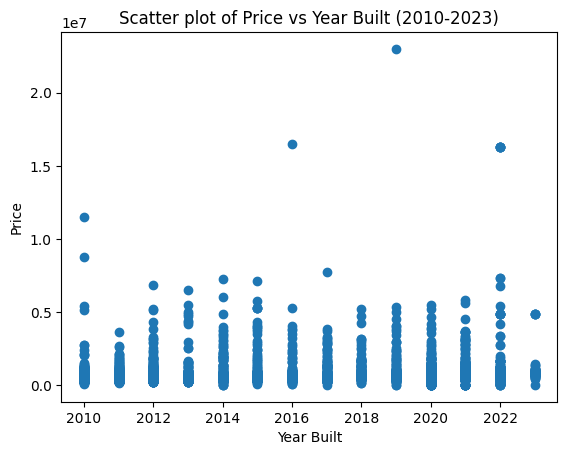

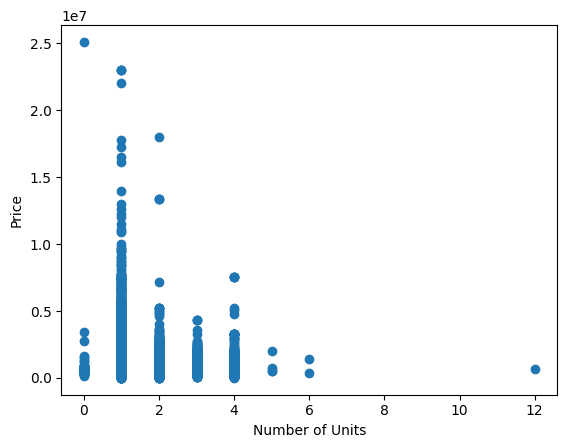

In [19]:
# Filter the data based on Year Built range

df_filtered = sales_trimmed_with_price[(sales_trimmed_with_price["AYB"] >= 2010) & (sales_trimmed_with_price["AYB"] <= 2023)]

plt.scatter(df_filtered["AYB"], df_filtered["PRICE"])
plt.xlabel("Year Built")
plt.ylabel("Price")
plt.title("Scatter plot of Price vs Year Built (2010-2023)")
plt.show()

# Scatter plot of num_units vs price
plt.scatter(sales_trimmed_with_price['NUM_UNITS'], sales_trimmed_with_price['PRICE'])
plt.xlabel('Number of Units')
plt.ylabel('Price')
plt.show()
#%%


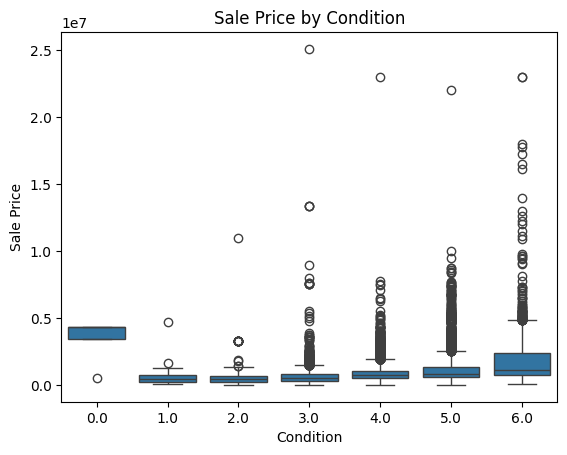

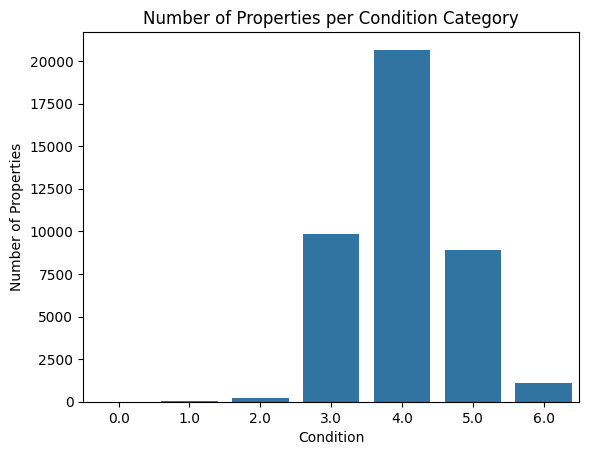

In [20]:
sns.boxplot(x="CNDTN", y="PRICE", data=sales_trimmed_with_price)
plt.title("Sale Price by Condition")
plt.xlabel("Condition")
plt.ylabel("Sale Price")
plt.show()
#%%
import seaborn as sns

sns.countplot(x='CNDTN', data=sales_trimmed_with_price)
plt.xlabel('Condition')
plt.ylabel('Number of Properties')
plt.title('Number of Properties per Condition Category')
plt.show()

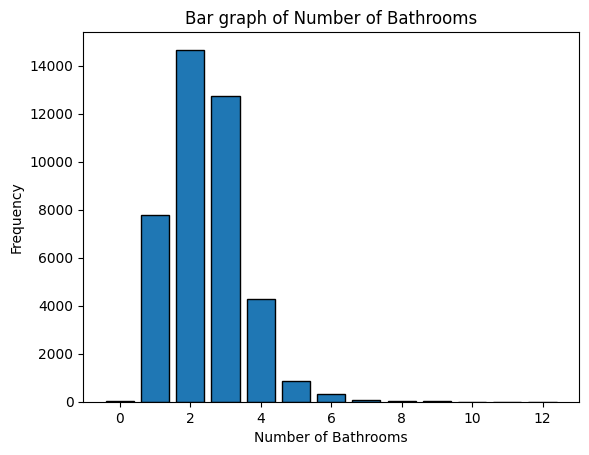

In [21]:
#%%

bathroom_freq = sales_trimmed_with_price["BATHRM"].value_counts().sort_index()
plt.bar(bathroom_freq.index, bathroom_freq.values, edgecolor='black')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Frequency")
plt.title("Bar graph of Number of Bathrooms")
plt.show()



In [ ]:
### Modeling

In [ ]:
### Building LR Model as price as indep to addrees the SMART Q
#This code is building a simple linear regression model to predict the price of a house based on three features: the number of bathrooms, the number of bedrooms, and the grade of the house.



In [22]:

# Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Drop rows with missing values
sales_trimmed_with_price = sales_trimmed_with_price.dropna()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GRADE']], sales_trimmed_with_price['PRICE'], test_size=0.2, random_state=42)

# Instantiate the linear regression model
fit1 = LinearRegression()

# Fit the model to the training data
fit1.fit(X_train, y_train)

# Make predictions on the test data
y_pred = fit1.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)


Mean squared error: 222491369275.8809
R-squared: 0.5834562818092952


In [ ]:
## Adding heat as predictor

In [23]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GRADE', 'HEAT']], sales_trimmed_with_price['PRICE'], test_size=0.2, random_state=42)

# Instantiate the linear regression model
fit2 = LinearRegression()

# Fit the model to the training data
fit2.fit(X_train, y_train)

# Make predictions on the test data
y_pred = fit2.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)



Mean squared error: 222194299619.7586
R-squared: 0.584012449446384


In [ ]:
#Adding the "heat" variable as a predictor didn't seem to have a significant impact on the model's performance, as the mean squared error and R-squared values are only slightly different from the previous model.
#Updated the code that includes heat and cndtn as additional predictor variables:

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GRADE', 'HEAT', 'CNDTN']],
    sales_trimmed_with_price['PRICE'],
    test_size=0.2,
    random_state=42
)

# Instantiate the linear regression model
fit3 = LinearRegression()

# Fit the model to the training data
fit3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = fit3.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)

# Print the coefficients of the model
print("Coefficients:", fit3.coef_)
'''Based on the output, we can see that the model with the additional predictor variables (heat and cndtn) has a lower mean squared error and a higher R-squared value compared to the model with only bathrm, bedrm, and grade. This suggests that the inclusion of heat and cndtn as predictor variables has improved the model's ability to predict the sale price of residential properties.

Is there a correlation between the grade and the sale price of a residential property in this dataset?
The coefficient for grade in the model is 303,631. This means that, all other variables being equal, a one-unit increase in the grade is associated with a $303,631 increase in the sale price of the property. This indicates that there is a strong positive correlation between the grade and the sale price of a residential property in this dataset.'''


Mean squared error: 201704236778.57108
R-squared: 0.6223735193144306
Coefficients: [168582.12174971  13941.38958968 303630.63614984   3206.28094951
 223677.38551315]


"Based on the output, we can see that the model with the additional predictor variables (heat and cndtn) has a lower mean squared error and a higher R-squared value compared to the model with only bathrm, bedrm, and grade. This suggests that the inclusion of heat and cndtn as predictor variables has improved the model's ability to predict the sale price of residential properties.\n\nIs there a correlation between the grade and the sale price of a residential property in this dataset?\nThe coefficient for grade in the model is 303,631. This means that, all other variables being equal, a one-unit increase in the grade is associated with a $303,631 increase in the sale price of the property. This indicates that there is a strong positive correlation between the grade and the sale price of a residential property in this dataset."

In [25]:
# Adding  gross building area (gba) as another predictor to the model: 


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GRADE', 'HEAT', 'CNDTN', 'GBA']],
    sales_trimmed_with_price['PRICE'],
    test_size=0.2,
    random_state=42
)

# Instantiate the linear regression model
fit4 = LinearRegression()

# Fit the model to the training data
fit4.fit(X_train, y_train)

# Make predictions on the test data
y_pred = fit4.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the summary
print("=== Linear Regression Summary ===")
print(f"Independent variables: {list(X_train.columns)}")
print(f"Dependent variable: price")
print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")
print(f"Mean squared error: {mse}")
print(f"R-squared: {r2}")
print(f"Coefficients: {fit4.coef_}")

'''By adding gross building area as an additional predictor, the performance of the model has improved, as indicated by the decrease in mean squared error and the increase in R-squared value. The coefficients of the model indicate that gross building area has the highest positive effect on price, followed by cndtn, grade, heat, bathrm, and bedrm. bedrm has a negative effect on price, which could indicate that more bedrooms are not always better for homebuyers, depending on other factors.

There is a correlation between the number of bedrooms and the sale price of a residential property in this dataset. However, the correlation is negative, meaning that as the number of bedrooms increases, the sale price tends to decrease.

 There is a correlation between the grade and the sale price of a residential property in this dataset. The correlation is positive, meaning that as the grade of the property increases, the sale price tends to increase as well.'''


=== Linear Regression Summary ===
Independent variables: ['BATHRM', 'BEDRM', 'GRADE', 'HEAT', 'CNDTN', 'GBA']
Dependent variable: price
Training data size: 22768
Test data size: 5692
Mean squared error: 164000452713.6728
R-squared: 0.6929617603566179
Coefficients: [ 46265.24253959 -79584.46083628 212828.91252361    476.6590613
 250701.28974968    442.81817169]


'By adding gross building area as an additional predictor, the performance of the model has improved, as indicated by the decrease in mean squared error and the increase in R-squared value. The coefficients of the model indicate that gross building area has the highest positive effect on price, followed by cndtn, grade, heat, bathrm, and bedrm. bedrm has a negative effect on price, which could indicate that more bedrooms are not always better for homebuyers, depending on other factors.\n\nThere is a correlation between the number of bedrooms and the sale price of a residential property in this dataset. However, the correlation is negative, meaning that as the number of bedrooms increases, the sale price tends to decrease.\n\n There is a correlation between the grade and the sale price of a residential property in this dataset. The correlation is positive, meaning that as the grade of the property increases, the sale price tends to increase as well.'

In [26]:
##  Adding num_days_passed as predictor to the model: 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GRADE', 'HEAT', 'CNDTN', 'GBA', 'num_days_passed']],
    sales_trimmed_with_price['PRICE'],
    test_size=0.2,
    random_state=42
)

# Instantiate the linear regression model
fit5 = LinearRegression()

# Fit the model to the training data
fit5.fit(X_train, y_train)

# Make predictions on the test data
y_pred = fit5.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)

# Print the coefficients of the model
print("Coefficients:", fit5.coef_)


'''A change in R-squared of 0.0365 (from 0.6929 to 0.7294) can be considered a moderate to large improvement in the model's predictive power,
especially if the dataset is large enough to provide a robust evaluation.'''


Mean squared error: 144529949504.21765
R-squared: 0.7294140318685705
Coefficients: [ 4.12141957e+04 -8.32798957e+04  2.10414766e+05  2.17435103e+02
  2.05181051e+05  4.60737848e+02  1.11456679e+02]


"A change in R-squared of 0.0365 (from 0.6929 to 0.7294) can be considered a moderate to large improvement in the model's predictive power,\nespecially if the dataset is large enough to provide a robust evaluation."

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
 
# Define the predictor variables
X = sales_trimmed_with_price[['BATHRM', 'BEDRM', 'GBA', 'CNDTN']]

# Define the threshold
threshold = 500000 

# Define the binary target variable
y = (sales_trimmed_with_price['PRICE'] > threshold).astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Gradient Boosting Classifier model
model_LG= GradientBoostingClassifier()

# Fit the model to the training data
model_LG.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model_LG.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# Prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Instantiate the Gradient Boosting Classifier model
model_LG = GradientBoostingClassifier()

# Evaluate the model using cross-validation
scores = cross_val_score(model_LG, X, y, cv=cv, n_jobs=-1)

# Report performance
print('Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

# The model performs well in predicting whether a property was sold for more than $500,000 or not.

#The accuracy of the model is 0.81, which means that 81% of the time the model predicts correctly whether the property was sold for more than $500,000 or not.

#The precision of the model is 0.84, which means that out of all the properties that the model predicted were sold for more than $500,000, 84% of them were actually sold for more than $500,000.

#The recall of the model is 0.93, which means that out of all the properties that were actually sold for more than $500,000, 93% of them were correctly identified by the model.


Accuracy: 0.8123682361208714
Precision: 0.8407494145199064
Recall: 0.92504099320684
Accuracy: 0.806 (0.007)


In [ ]:
### COVID Comparison
# Split to 3 periods(Ex Ante, lockdown, Ex Post)


In [28]:

from datetime import datetime
sales["sale_year"] = sales["SALEDATE"].dt.date

a=datetime.strptime('01-01-2019', '%m-%d-%Y').date()
b=datetime.strptime('02-29-2020', '%m-%d-%Y').date()
c=datetime.strptime('03-01-2020', '%m-%d-%Y').date()
d=datetime.strptime('07-31-2020', '%m-%d-%Y').date()
e=datetime.strptime('08-01-2020', '%m-%d-%Y').date()
f=datetime.strptime('12-31-2022', '%m-%d-%Y').date()

#d=pd.to_datetime('2022-12-31')

sales_trimmed = sales[(sales["sale_year"] >=a) & (sales["sale_year"] <= f) & sales["PRICE"].notnull()].drop(cols_to_drop, axis = 1)

periods = [
    {'start': a, 'end': b, 'name': 'ExAnte'},
    {'start': c, 'end': d, 'name': 'Lock_down'},
    {'start': e, 'end': f, 'name': 'ExPost'}
]
def assign_period(row):
    sale_year = row['sale_year']
    for period in periods:
        if period['start'] <= sale_year <= period['end']:
            return period['name']
    return 'Unknown'

sales_trimmed['period'] = sales_trimmed.apply(assign_period, axis=1)
print(sales_trimmed['period'])

# %%
sales_num_trimmed = sales[(sales["sale_year"] >= a) & (sales["sale_year"] <= f) & sales["SALE_NUM"].notnull()].drop(cols_to_drop, axis = 1)

def assign_period(row):
    sale_year = row['sale_year']
    for period in periods:
        if period['start'] <= sale_year <= period['end']:
            return period['name']
    return 'Unknown'

sales_num_trimmed['period'] = sales_num_trimmed.apply(assign_period, axis=1)
print(sales_num_trimmed['period'])

0         ExPost
2         ExPost
4         ExPost
8         ExPost
13        ExPost
           ...  
108498    ExAnte
108500    ExPost
108503    ExPost
108512    ExAnte
108515    ExPost
Name: period, Length: 28026, dtype: object
0         ExPost
2         ExPost
4         ExPost
8         ExPost
13        ExPost
           ...  
108498    ExAnte
108500    ExPost
108503    ExPost
108512    ExAnte
108515    ExPost
Name: period, Length: 28026, dtype: object


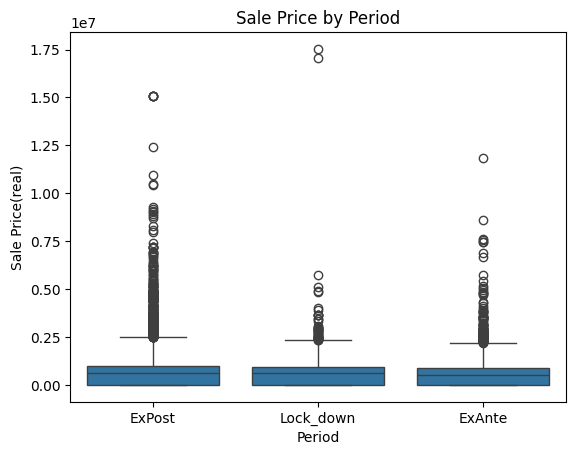

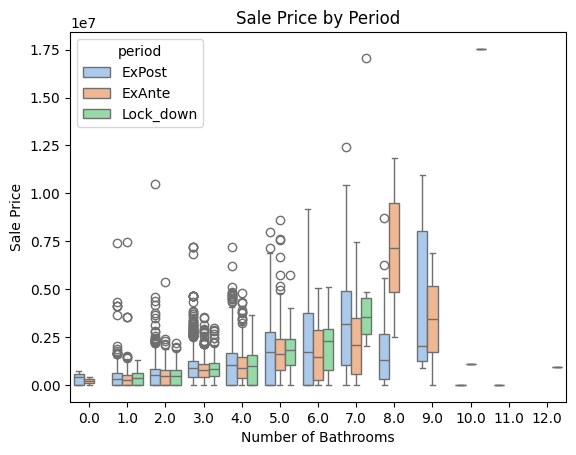

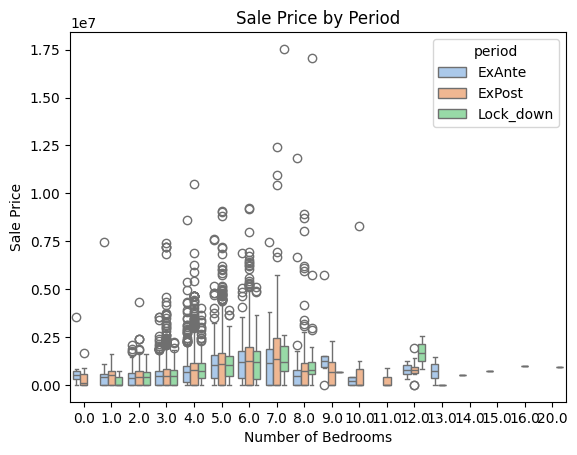

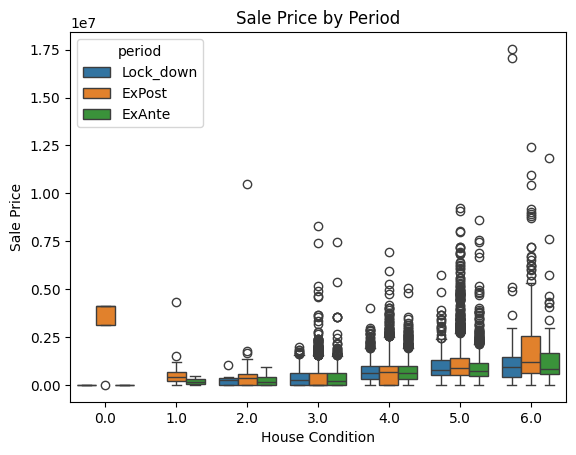

In [29]:

## Boxplot of residential sale prices in 3 periods(Ex Ante, lockdown, Ex Post)

g=datetime.strptime('01-01-2019', '%m-%d-%Y').date()
h=datetime.strptime('12-31-2019', '%m-%d-%Y').date()
i=datetime.strptime('12-31-2020', '%m-%d-%Y').date()
j=datetime.strptime('12-31-2021', '%m-%d-%Y').date()
k=datetime.strptime('12-31-2022', '%m-%d-%Y').date()
years=[g,h,i,j]

sales_trimmed['Real_price'] = sales_trimmed.apply(lambda row: row['PRICE'] /1.018 if row['sale_year'] < h and row['sale_year']>=g
                           else row['PRICE'] /1.012 if row['sale_year'] < i and row['sale_year']>=h
                           else row['PRICE'] /1.047 if row['sale_year'] < j and row['sale_year']>=i
                           else row['PRICE'] /1.08, axis=1)


sales_trimmed['Inflation'] = sales_trimmed.apply(lambda row: 1.018 if row['sale_year'] < h and row['sale_year']>=g
                           else 1.012 if row['sale_year'] < i and row['sale_year']>=h
                           else 1.047 if row['sale_year'] < j and row['sale_year']>=i
                           else 1.08, axis=1)


# %%
sns.boxplot(x="period", y="Real_price", data=sales_trimmed)
plt.title("Sale Price by Period")
plt.xlabel("Period")
plt.ylabel("Sale Price(real)")
plt.show()
# %%
sns.boxplot(x="BATHRM", y="Real_price",hue="period", data=sales_trimmed, palette="pastel")
plt.title("Sale Price by Period")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Sale Price")
plt.show()
# %%
sns.boxplot(x="BEDRM", y="Real_price",hue="period", palette="pastel", data=sales_trimmed)
plt.title("Sale Price by Period")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Sale Price")
plt.show()
# %%

sns.boxplot(x="CNDTN", y="Real_price",hue="period", data=sales_trimmed)
plt.title("Sale Price by Period")
plt.xlabel("House Condition")
plt.ylabel("Sale Price")
plt.show()

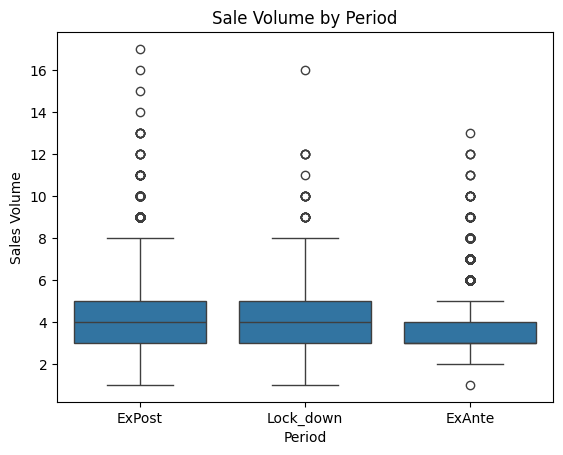

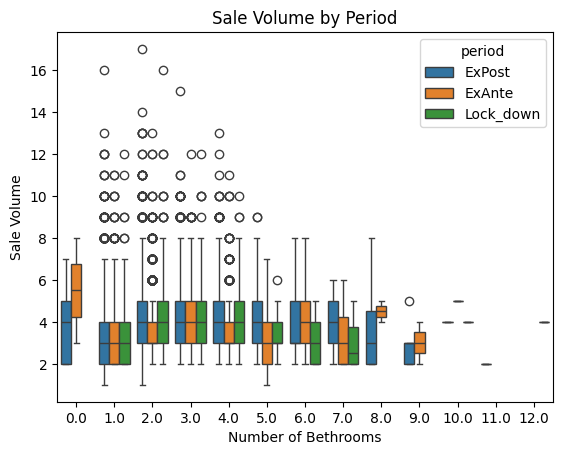

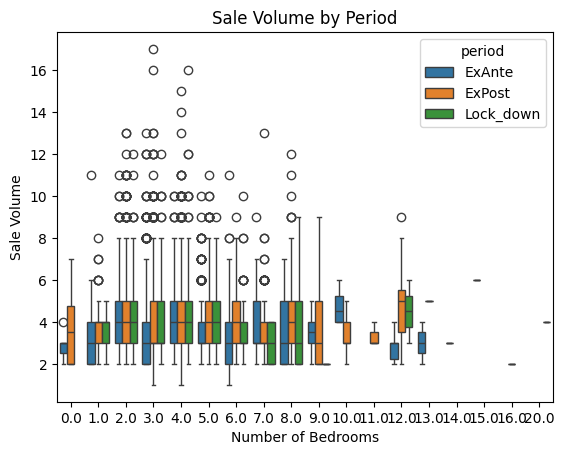

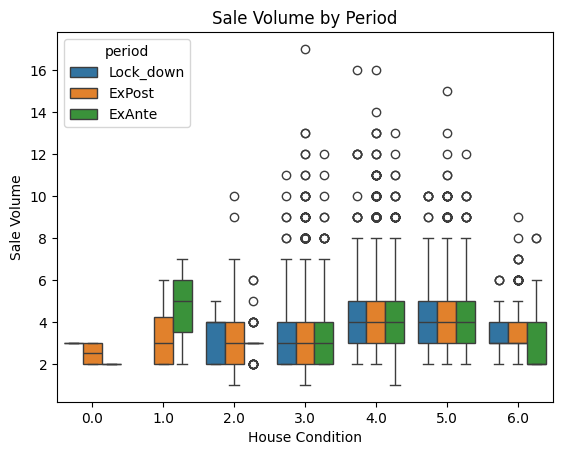

In [30]:
## Boxplot of residential sales numbers in 3 periods(Ex Ante, lockdown, Ex Post)

sns.boxplot(x="period", y="SALE_NUM", data=sales_num_trimmed)
plt.title("Sale Volume by Period")
plt.xlabel("Period")
plt.ylabel("Sales Volume")
plt.show()
# %%
sns.boxplot(x="BATHRM", y="SALE_NUM",hue="period", data=sales_num_trimmed)
plt.title("Sale Volume by Period")
plt.xlabel("Number of Bethrooms")
plt.ylabel("Sale Volume")
plt.show()
# %%
sns.boxplot(x="BEDRM", y="SALE_NUM",hue="period", data=sales_num_trimmed)
plt.title("Sale Volume by Period")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Sale Volume")
plt.show()
# %%

sns.boxplot(x="CNDTN", y="SALE_NUM",hue="period", data=sales_num_trimmed)
plt.title("Sale Volume by Period")
plt.xlabel("House Condition")
plt.ylabel("Sale Volume")
plt.show()

In [31]:
# Anova test of residential sale prices in 3 periods(Ex Ante, lockdown, Ex Post)
import statsmodels.api as sm
from statsmodels.formula.api import ols
model_1 = ols('Real_price ~ C(period)', data=sales_trimmed).fit()
anova_table = sm.stats.anova_lm(model_1, typ=2)
anova_table
# %%
model_2 = ols('SALE_NUM ~ C(period)', data=sales_num_trimmed).fit()
anova_table = sm.stats.anova_lm(model_2, typ=2)
anova_table
# %%

# Impact of Covid on housing price and saliling number
from statsmodels.formula.api import glm
model3=glm(formula='Real_price ~C(period)+BATHRM+BEDRM+CNDTN+GBA', data=sales_trimmed).fit()
print(model3.summary())
model4=glm(formula='SALE_NUM ~C(period)+BATHRM+BEDRM+CNDTN+GBA', data=sales_num_trimmed).fit()
print(model4.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             Real_price   No. Observations:                27163
Model:                            GLM   Df Residuals:                    27156
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                      3.8208e+11
Method:                          IRLS   Log-Likelihood:            -4.0074e+05
Date:                Fri, 01 Dec 2023   Deviance:                   1.0376e+16
Time:                        16:37:43   Pearson chi2:                 1.04e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3699
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.02